# Apprentice Chef, round two

I wanted to see if I can improve on what I did when I first started ML. We were given two assignments to do with this dataset:

1. Estimate the revenue brought in by a customer.

2. Classify whether a customer would be succeptible to cross-selling of a different service.

While in school I reached an r-squared of 0.80 for task 1, and an auc score of 0.797 for task 2. I will admit that reaching scores of 0.8 on these was the difference between a B and a C, while 0.9 was required for an A. Let's see if we can get that! 

I'll be using this notebook for exploratory analysis and a final write-up, while the rest of the code will be in scripts.

## Exploratory analysis

I'll begin by importing and looking at the data, see if there are any interesting ideas that pop out.

In [12]:
import pandas as pd                 # Data science essentials
import matplotlib.pyplot as plt            # Plotting essentials
import seaborn as sns               # More advanced plotting
import numpy as np

%matplotlib notebook
%matplotlib inline

from IPython.display import clear_output        # Clear output to keep things clean


In [2]:
dataset = pd.read_excel('Datasets/Apprentice_Chef_Dataset.xlsx')


First we need to make sure that the data is in the correct type. What data is numerical and what is categorical?\n
For this I'll make a type dictionary.

In [3]:
type_dict = {'REVENUE':                         'float64',  # Revenue by client, numerical
             'CROSS_SELL_SUCCESS':              'int64',    # Whether a client has purchased the other service, binary categorical
             'NAME':                            'object',   # Full name of client, string
             'EMAIL':                           'object',   # Email provided by client, string
             'FIRST_NAME':                      'object',   # First name of client, string
             'FAMILY_NAME':                     'object',   # Any other names of client, string
             'TOTAL_MEALS_ORDERED':             'int64',    # Number of meals ordered, integer
             'UNIQUE_MEALS_PURCH':              'int64',    # Number of unique meals ordered, integer
             'CONTACTS_W_CUSTOMER_SERVICE':     'int64',    # How many times the client contacted customer service, integer 
             'PRODUCT_CATEGORIES_VIEWED':       'int64',    # How many different meals the client has viewed, integer
             'AVG_TIME_PER_SITE_VISIT':         'float64',  # How long a client spends on the site per visit, float
             'MOBILE_NUMBER':                   'int64',    # Whether a client has registered a mobile phone number, binary categorical
             'CANCELLATIONS_BEFORE_NOON':       'int64',    # How many times a client has cancelled their order before noon, integer
             'CANCELLATIONS_AFTER_NOON':        'int64',    # How many times a client has cancelled their order after noon, integer
             'TASTES_AND_PREFERENCES':          'int64',    # Whether a client has specified their preferences, binary categorical
             'MOBILE_LOGINS':                   'int64',    # How many times the client has logged in from a mobile device, integer
             'PC_LOGINS':                       'int64',    # How many times the client has logged in from other devices, integer
             'WEEKLY_PLAN':                     'int64',    # Number of times the client has ordered the weekly plan, integer
             'EARLY_DELIVERIES':                'int64',    # Number of times the client has received an early delivery, integer
             'LATE_DELIVERIES':                 'int64',    # Number of timee the client has received a late delivery, integer
             'PACKAGE_LOCKER':                  'int64',    # If the client has a package room, binary categorical
             'REFRIGERATED_LOCKER':             'int64',    # If the package room is refrigerated, binary categorical
             'FOLLOWED_RECOMMENDATIONS_PCT':    'int64',    # How often the client followed the meal recommendations, integer
             'AVG_PREP_VID_TIME':               'float64',  # How long the client watches prep videos on average, float
             'LARGEST_ORDER_SIZE':              'int64',    # Largest number of meals in one order, integer
             'MASTER_CLASSES_ATTENDED':         'int64',    # How many classes the client has attended, integer
             'MEDIAN_MEAL_RATING':              'int64',    # The median rating given by client, integer
             'AVG_CLICKS_PER_VISIT':            'float64',  # How many clicks per visit on average, float
             'TOTAL_PHOTOS_VIEWED':             'int64'     # How many photos the client has viewed, integer
             }

dataset = dataset.astype(type_dict)
print(dataset.info())                   # Checking that they are now the correct datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REVENUE                       1946 non-null   float64
 1   CROSS_SELL_SUCCESS            1946 non-null   int64  
 2   NAME                          1946 non-null   object 
 3   EMAIL                         1946 non-null   object 
 4   FIRST_NAME                    1946 non-null   object 
 5   FAMILY_NAME                   1899 non-null   object 
 6   TOTAL_MEALS_ORDERED           1946 non-null   int64  
 7   UNIQUE_MEALS_PURCH            1946 non-null   int64  
 8   CONTACTS_W_CUSTOMER_SERVICE   1946 non-null   int64  
 9   PRODUCT_CATEGORIES_VIEWED     1946 non-null   int64  
 10  AVG_TIME_PER_SITE_VISIT       1946 non-null   float64
 11  MOBILE_NUMBER                 1946 non-null   int64  
 12  CANCELLATIONS_BEFORE_NOON     1946 non-null   int64  
 13  CAN

Now I want to go through the variables to see if there is anything we can do with them. These are the ones I want to do something with, and what I want to do:

* Name
    * I want to count how many parts the name has.
    * I want to remove all parts of a name inside parentheses, but I will first flag that the name has parentheses.
    * Identify if the last name is one of the "bastard" names from Game of Thrones (Snow, Rivers, Sand, Flowers, Hill, Pyke, Stone, Storm, Waters).
    * Identify if the last name is in one of the 5 most common (Frey, Lannister, Targaryen, Stark, Tyrell)
    * Identify if the first name is in one of the 10 most common (Jon, Jeyne, Aegon, Walder, Alyn, Lyonel, Steffon, Brandon, Pate, Robin)
    

* Email
    * Because the email adresses are in the format of 'Name' + domain I will only look at the domain since the name is its own variable.

    * For the domains I will split them into the groups given in the case description: professional, personal, and junk.

* Weekly Plan
    * I'll see if I can feature the discounts provided by ordering a weekly set, though I think it might show itself by itself.

* Revenue, Total Meals, Unique Meals
    * For the classification task I will try to use the provided meal and beverages tables to see if I can get any insight there. Perhaps a client has trends that make them more likely to go for the cross-sell.

* Total Photos Viewed
    * I'll use this and the number of visits to get Photos viewed per visit.


In [4]:
from src.cleaning.cleaning_data import *
from src.extraction.outliers import *

In [5]:
## Flagging names with parentheses

dataset['parentheses'] = [has_character(name, "(") for name in dataset['NAME']]

## Removing whatever is in parentheses
parenthesesPattern = r".*?(\s\(.*?\))"
dataset.NAME = [remove_pattern(name, parenthesesPattern).strip() for name in dataset.NAME]
dataset.head()



,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,parentheses
0,1880.0,1,Addam Osgrey,addam.osgrey@passport.com,Addam,Osgrey,118,4,7,5,...,1,0,90,165.8,6,1,3,11.0,0,0
1,1495.0,1,Aegon Blackfyre,aegon.blackfyre@jnj.com,Aegon,Blackfyre,44,3,6,3,...,1,0,90,150.5,4,1,3,13.0,90,0
2,2572.5,1,Aegon Frey,aegon.frey.(son.of.aenys)@gmail.com,Aegon,Frey,38,1,5,3,...,0,0,80,99.6,3,0,3,12.0,0,1
3,1647.0,1,Aegon Targaryen,aegon.targaryen.(son.of.rhaegar)@ibm.com,Aegon,Targaryen,76,3,8,10,...,0,0,90,125.0,3,0,3,13.0,0,1
4,1923.0,1,Aegon V Targaryen,aegon.v.targaryen@goldmansacs.com,Aegon,V Targaryen,65,3,6,9,...,1,0,90,135.3,3,1,3,13.0,253,0


In [6]:
## Adding the number of parts of the names

dataset["PartsOfName"] = [len(name.split(" ")) for name in dataset.NAME]

bastardNameSet = set(['Snow', 'Rivers', 'Sand', 'Flowers', 'Hill', 'Pyke', 'Stone', 'Storm', 'Waters'])
bigNameSet = set(["Frey", "Lannister", "Stark", "Tyrell", "Targaryen"])
commonFirstNameSet = set(['Jon', 'Jeyne', 'Aegon', 'Walder', 'Alyn', 'Lyonel', 'Steffon', 'Brandon', 'Pate', 'Robin'])

dataset.FAMILY_NAME = [name.split(" ")[-1] for name in dataset.NAME]
dataset.FIRST_NAME = [name.split(" ")[0] for name in dataset.NAME]

dataset["IsBastard"] = [1 if lastName in bastardNameSet else 0 for lastName in dataset.FAMILY_NAME]
dataset["IsBigName"] = [1 if lastName in bigNameSet else 0 for lastName in dataset.FAMILY_NAME]
dataset["IsCommonName"] = [1 if firstName in commonFirstNameSet else 0 for firstName in dataset.FIRST_NAME]



In [7]:
dataset["IsProfessionalEmail"] = generate_list(classify_domain, dataset.EMAIL, domain_type="professional")
dataset["IsPersonalEmail"] = generate_list(classify_domain, dataset.EMAIL, domain_type="personal")

In [8]:
dataset['TotalLogins'] = dataset.MOBILE_LOGINS + dataset.PC_LOGINS   # I'm unsure if the user can remain logged in ou not
dataset['PhotosViewedPerVisit'] = dataset.TOTAL_PHOTOS_VIEWED / dataset.TotalLogins 
dataset['RevenuePerMeal'] = dataset.REVENUE / dataset.TOTAL_MEALS_ORDERED

In [9]:
dataset.head(-5)

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,parentheses,PartsOfName,IsBastard,IsBigName,IsCommonName,IsProfessionalEmail,IsPersonalEmail,TotalLogins,PhotosViewedPerVisit,RevenuePerMeal
0,1880.0,1,Addam Osgrey,addam.osgrey@passport.com,Addam,Osgrey,118,4,7,5,...,0,2,0,0,0,0,0,8,0.000000,15.932203
1,1495.0,1,Aegon Blackfyre,aegon.blackfyre@jnj.com,Aegon,Blackfyre,44,3,6,3,...,0,2,0,0,1,1,0,7,12.857143,33.977273
2,2572.5,1,Aegon Frey,aegon.frey.(son.of.aenys)@gmail.com,Aegon,Frey,38,1,5,3,...,1,2,0,1,1,0,1,8,0.000000,67.697368
3,1647.0,1,Aegon Targaryen,aegon.targaryen.(son.of.rhaegar)@ibm.com,Aegon,Targaryen,76,3,8,10,...,1,2,0,1,1,1,0,7,0.000000,21.671053
4,1923.0,1,Aegon V Targaryen,aegon.v.targaryen@goldmansacs.com,Aegon,Targaryen,65,3,6,9,...,0,3,0,1,1,1,0,8,31.625000,29.584615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,590.0,0,Rolland Uffering,rolland.uffering@aol.com,Rolland,Uffering,15,8,12,3,...,0,2,0,0,0,0,0,6,0.000000,39.333333
1937,2240.0,0,Rhae Targaryen,rhae.targaryen@passport.com,Rhae,Targaryen,76,1,5,10,...,0,2,0,1,0,0,0,7,0.000000,29.473684
1938,1850.0,0,Jeyne Lothston,jeyne.lothston@passport.com,Jeyne,Lothston,47,8,4,7,...,0,2,0,0,1,0,0,6,0.000000,39.361702
1939,980.0,0,Aerys I Targaryen,aerys.i.targaryen@msn.com,Aerys,Targaryen,15,9,11,8,...,0,3,0,1,0,0,0,7,0.000000,65.333333


In [10]:
dataset.columns

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 'FIRST_NAME',
       'FAMILY_NAME', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH',
       'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
       'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
       'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'MOBILE_LOGINS',
       'PC_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
       'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
       'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
       'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED',
       'parentheses', 'PartsOfName', 'IsBastard', 'IsBigName', 'IsCommonName',
       'IsProfessionalEmail', 'IsPersonalEmail', 'TotalLogins',
       'PhotosViewedPerVisit', 'RevenuePerMeal'],
      dtype='object')

In [11]:
regressionList = [
    'REVENUE',
    'CROSS_SELL_SUCCESS',
    'TOTAL_MEALS_ORDERED',
    'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE',
    'PRODUCT_CATEGORIES_VIEWED',
    'AVG_TIME_PER_SITE_VISIT',
    'MOBILE_NUMBER', 
    'CANCELLATIONS_BEFORE_NOON',
    'CANCELLATIONS_AFTER_NOON', 
    'TASTES_AND_PREFERENCES', 
    'MOBILE_LOGINS',
    'PC_LOGINS', 
    'WEEKLY_PLAN', 
    'EARLY_DELIVERIES', 
    'LATE_DELIVERIES',
    'PACKAGE_LOCKER', 
    'REFRIGERATED_LOCKER', 
    'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME', 
    'LARGEST_ORDER_SIZE', 
    'MASTER_CLASSES_ATTENDED',
    'MEDIAN_MEAL_RATING', 
    'AVG_CLICKS_PER_VISIT', 
    'TOTAL_PHOTOS_VIEWED',
    'parentheses', 
    'PartsOfName', 
    'IsBastard', 
    'IsBigName', 
    'IsCommonName',
    'IsProfessionalEmail', 
    'IsPersonalEmail', 
    'TotalLogins',
    'PhotosViewedPerVisit']

regressionListNoFeatures = [
    'REVENUE',
    'CROSS_SELL_SUCCESS',
    'TOTAL_MEALS_ORDERED',
    'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE',
    'PRODUCT_CATEGORIES_VIEWED',
    'AVG_TIME_PER_SITE_VISIT',
    'MOBILE_NUMBER', 
    'CANCELLATIONS_BEFORE_NOON',
    'CANCELLATIONS_AFTER_NOON', 
    'TASTES_AND_PREFERENCES', 
    'MOBILE_LOGINS',
    'PC_LOGINS', 
    'WEEKLY_PLAN', 
    'EARLY_DELIVERIES', 
    'LATE_DELIVERIES',
    'PACKAGE_LOCKER', 
    'REFRIGERATED_LOCKER', 
    'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME', 
    'LARGEST_ORDER_SIZE', 
    'MASTER_CLASSES_ATTENDED',
    'MEDIAN_MEAL_RATING', 
    'AVG_CLICKS_PER_VISIT', 
    'TOTAL_PHOTOS_VIEWED']

classificationList = [
    'CROSS_SELL_SUCCESS',
    'REVENUE',
    'TOTAL_MEALS_ORDERED',
    'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE',
    'PRODUCT_CATEGORIES_VIEWED',
    'AVG_TIME_PER_SITE_VISIT',
    'MOBILE_NUMBER', 
    'CANCELLATIONS_BEFORE_NOON',
    'CANCELLATIONS_AFTER_NOON', 
    'TASTES_AND_PREFERENCES', 
    'MOBILE_LOGINS',
    'PC_LOGINS', 
    'WEEKLY_PLAN', 
    'EARLY_DELIVERIES', 
    'LATE_DELIVERIES',
    'PACKAGE_LOCKER', 
    'REFRIGERATED_LOCKER', 
    'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME', 
    'LARGEST_ORDER_SIZE', 
    'MASTER_CLASSES_ATTENDED',
    'MEDIAN_MEAL_RATING', 
    'AVG_CLICKS_PER_VISIT', 
    'TOTAL_PHOTOS_VIEWED',
    'parentheses', 
    'PartsOfName', 
    'IsBastard', 
    'IsBigName', 
    'IsCommonName',
    'IsProfessionalEmail', 
    'IsPersonalEmail', 
    'TotalLogins',
    'PhotosViewedPerVisit',
    'RevenuePerMeal']

classificationListNoFeatures = classificationList = [
    'CROSS_SELL_SUCCESS',
    'REVENUE',
    'TOTAL_MEALS_ORDERED',
    'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE',
    'PRODUCT_CATEGORIES_VIEWED',
    'AVG_TIME_PER_SITE_VISIT',
    'MOBILE_NUMBER', 
    'CANCELLATIONS_BEFORE_NOON',
    'CANCELLATIONS_AFTER_NOON', 
    'TASTES_AND_PREFERENCES', 
    'MOBILE_LOGINS',
    'PC_LOGINS', 
    'WEEKLY_PLAN', 
    'EARLY_DELIVERIES', 
    'LATE_DELIVERIES',
    'PACKAGE_LOCKER', 
    'REFRIGERATED_LOCKER', 
    'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME', 
    'LARGEST_ORDER_SIZE', 
    'MASTER_CLASSES_ATTENDED',
    'MEDIAN_MEAL_RATING', 
    'AVG_CLICKS_PER_VISIT', 
    'TOTAL_PHOTOS_VIEWED']



regressionDataset = dataset[regressionList]
regressionDatasetNoFeatures = dataset[regressionListNoFeatures]
classificationDataset = dataset[classificationList]
classificationDatasetNoFeatures = dataset[classificationListNoFeatures]

In [18]:
regressionDatasetNoFeatures.head()

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,...,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,1880.0,1,118,4,7,5,86.00,1,2,1,...,2,1,0,90,165.8,6,1,3,11.0,0
1,1495.0,1,44,3,6,3,125.60,1,0,1,...,4,1,0,90,150.5,4,1,3,13.0,90
2,2572.5,1,38,1,5,3,58.00,1,5,0,...,0,0,0,80,99.6,3,0,3,12.0,0
3,1647.0,1,76,3,8,10,45.51,0,3,0,...,4,0,0,90,125.0,3,0,3,13.0,0
4,1923.0,1,65,3,6,9,106.00,1,1,1,...,4,1,0,90,135.3,3,1,3,13.0,253


Now we have some features, but I want to see if any of them actually help. So we'll be doing a quick linear regression, and logistic regressions on the datasets to see if they help.

In [86]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

Linear Regression with no new features 

In [49]:
regression = {}

In [51]:
X = regressionDatasetNoFeatures.drop('REVENUE', axis=1)
y = regressionDatasetNoFeatures.REVENUE
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['Baseline'] = np.mean(n_scores)
print(f"R2: {regression['Baseline']}")

R2: 0.6224096134985444


Linear Regression with new features

In [52]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['categorical_features']=np.mean(n_scores)
print(f"R2: {regression['categorical_features']}")

R2: 0.622369527137067


The R2 score is basically unchanged, perhaps this is due to introducing covariance with confounding variables.
Nothing to worry about, we now have our baseline. Let's move on to the Logistic regression!

No new features:

In [53]:
classification = {}

In [54]:
X = classificationDatasetNoFeatures.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDatasetNoFeatures.CROSS_SELL_SUCCESS
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['Baseline'] = np.mean(n_scores)
print(f"AUC: {classification['Baseline']}")

AUC: 0.6096860834762722


In [55]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['categorical_features'] = np.mean(n_scores)
print(f"AUC: {classification['categorical_features']}")

AUC: 0.6096860834762722


The AUC score didn't change, though we now have our baseline! Now I'm going to apply a scaler to see how that changes things. 

In [57]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
scaler = StandardScaler()
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['scaled']=np.mean(n_scores)
print(f"R2: {regression['scaled']}")

R2: 0.6258701824287197


In [58]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['scaled'] = np.mean(n_scores)
print(f"AUC: {classification['scaled']}")

AUC: 0.7383222412807319


As we can see the classification earned more from the scaling, which is expected as a Logistic Regression is more sensitive to that. Now I just want to test if binning the continuous variables will do anything. It should detect outliers, and I'm guessing the classifier will gain more from this as well.

In [64]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
binner = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
scaler = StandardScaler()
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('binner',binner),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['binned']=np.mean(n_scores)
print(f"R2: {regression['binned']}")

C:\Users\matsl\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\matsl\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\matsl\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\matsl\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the

R2: 0.6023709145720642


In [65]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
binner = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('binner',binner),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['binned'] = np.mean(n_scores)
print(f"AUC: {classification['binned']}")

AUC: 0.7042597255574614


This didn't seem to help so we'll skip this. I'm going to try using the Robust Scaler instead of the standard scaler.

In [69]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
scaler = RobustScaler()
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['robust_scaler']=np.mean(n_scores)
print(regression)

{'Baseline': 0.6224096134985444, 'categorical_features': 0.622369527137067, 'scaled': 0.6258701824287197, 'binned': 0.6023709145720642, 'robust_scaler': 0.6201743571173732}


In [79]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
scaler = RobustScaler()
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['robust_scaler'] = np.mean(n_scores)
print(classification)

{'Baseline': 0.6096860834762722, 'categorical_features': 0.6096860834762722, 'scaled': 0.7383222412807319, 'binned': 0.7042597255574614, 'robust_scaler': 0.7389254316752429}


Let's try with PCA and a standard Scaler!

In [77]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
pca = PCA()
scaler = StandardScaler()
model = LinearRegression()
rfecv = RFECV(estimator=LinearRegression())
pipeline = Pipeline(steps=[('pca',pca),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2')
regression['PCA_standard']=np.mean(n_scores)
print(regression)

{'Baseline': 0.6224096134985444, 'categorical_features': 0.622369527137067, 'scaled': 0.6258701824287197, 'binned': 0.6023709145720642, 'robust_scaler': 0.6201743571173732, 'PCA_standard': 0.6237975363512585}


In [80]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
pca = PCA()
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)
rfecv = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('pca',pca),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['PCA_standard'] = np.mean(n_scores)
print(classification)

{'Baseline': 0.6096860834762722, 'categorical_features': 0.6096860834762722, 'scaled': 0.7383222412807319, 'binned': 0.7042597255574614, 'robust_scaler': 0.7389254316752429, 'PCA_standard': 0.7549896397941681}


Let's try with a different model!

In [85]:
X = regressionDataset.drop('REVENUE', axis=1)
y = regressionDataset.REVENUE
pca = PCA()
scaler = StandardScaler()
model = GradientBoostingRegressor()
rfecv = RFECV(estimator=GradientBoostingRegressor())
pipeline = Pipeline(steps=[('pca',pca),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='r2', n_jobs=-1)
regression['GBR']=np.mean(n_scores)
print(regression)

{'Baseline': 0.6224096134985444, 'categorical_features': 0.622369527137067, 'scaled': 0.6258701824287197, 'binned': 0.6023709145720642, 'robust_scaler': 0.6201743571173732, 'PCA_standard': 0.6237975363512585, 'GBR': 0.6713343120760511}


In [89]:
X = classificationDataset.drop('CROSS_SELL_SUCCESS', axis=1)
y = classificationDataset.CROSS_SELL_SUCCESS
pca = PCA()
scaler = StandardScaler()
model = GradientBoostingClassifier()
rfecv = RFECV(estimator=GradientBoostingClassifier())
pipeline = Pipeline(steps=[('pca',pca),('scaler',scaler),('s',rfecv),('m',model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc',n_jobs=-1)
classification['GBC'] = np.mean(n_scores)
print(classification)

array([ True,  True, False,  True, False,  True,  True,  True, False,
        True, False, False,  True, False,  True, False, False,  True,
        True, False, False, False,  True,  True])

CROSS_SELL_SUCCESS


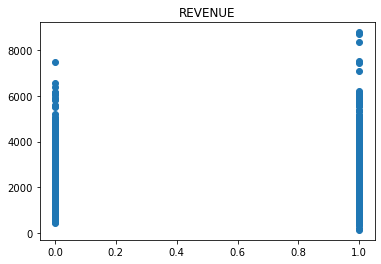

Please enter a valid value (int, float, or 'None')
Please enter a valid value (int, float, or 'None')
Please enter a valid value (int, float, or 'None')
Please enter a valid value (int, float, or 'None')
Please enter a valid value (int, float, or 'None')
Please enter a valid value (int, float, or 'None')


TypeError: '<=' not supported between instances of 'int' and 'str'

In [12]:
outlierDict = dict()
for column in regressionList:
    regressionDataset, outlierDict = scatter_outliers(regressionDataset, "REVENUE", column, outlierDict)
    clear_output()

In [ ]:
dataset.to_csv("Datasets/test.csv", index=False)